In [38]:
import numpy as np#
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import OrderedDict
from tqdm import tqdm 
from scipy import optimize, linalg
cmaps = OrderedDict()
cmaps['Diverging'] = [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

In [30]:
amps = np.arange(0.01,3,.1)
tot_L = 7
ells = range(1,tot_L)
ps = np.zeros((tot_L, len(amps)))
channel_params="[{} 1.  ]".format(0.01)
for indL in tqdm(ells):
    for inda, a in enumerate(amps):
        ps[indL, inda] = np.load("/data/uab-giq/scratch/matias/dynamo/{}/{}/{}/Ps.npy".format(channel_params,indL,np.round(a,3)))[0, 10]


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


In [39]:
def hel(alpha):
    return (1+np.sqrt(1-np.exp(-4*alpha**2)))/2


def homodyne_success(a):
    return (1+ erf(np.sqrt(2)*a))/2

def fading_homodyne_success(a, epsilon1=1e-2,epsilon2=1. ,pat0=0.5):
    return pat0*homodyne_success(np.sqrt(epsilon1)*a) + (1-pat0)*homodyne_success(np.sqrt(epsilon2)*a)



def overlap(a1,a2):
    return np.exp(-0.5*abs(a1-a2)**2)

def rho0(B, pr_at0=0.5):
    return pr_at0*np.outer(*[B[:,0]]*2) + (1-pr_at0)*np.outer(*[B[:,1]]*2)
def rho1(B, pr_at0=0.5):
    return pr_at0*np.outer(*[B[:,2]]*2) + (1-pr_at0)*np.outer(*[B[:,3]]*2)

def helstrom_success_fun(amplitude, epsilon1=1e-2, epsilon2=1.):
    at1 = np.sqrt(epsilon1)
    at2 = np.sqrt(epsilon2)
    a1=amplitude
    a2=-amplitude
    gram = np.zeros((4,4))
    for indi, i in enumerate([at1*a1, at2*a1, at1*a2, at2*a2]):
        for indj, j in enumerate([at1*a1, at2*a1, at1*a2, at2*a2]):
            gram[indi,indj] = overlap(i,j)
    B = linalg.sqrtm(gram)
    q0 = 0.5
    q1 = 1-q0
    rho = q0*rho0(B) - q1*rho1(B)
    trace_norm = np.sum(np.abs(np.linalg.eigvals(rho)))
    helstrom_success = (1+trace_norm)/2
    return helstrom_success

Text(0.5, 1.0, 'Dolinar-like receiver for BPSK quantum discrimination of coherent states')

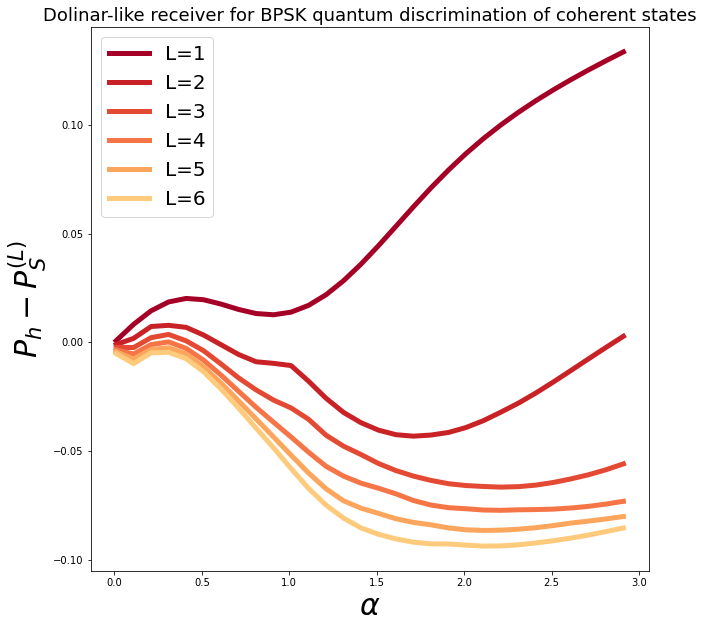

In [40]:
name = "RdYlBu"
cc=cm.get_cmap(name)
plt.figure(figsize=(10,10))
ax1 = plt.subplot(111)
lw=5
colors = {0:"red",1:"blue",2:"pink",3:"black"}
ind=0
tot=14
for layer in range(1,tot_L):
    ax1.plot(amps,np.array([helstrom_success_fun(a) for a in amps]) - 1 + ps[layer], label="L="+str(layer), linewidth=lw, color=cc(ind/tot))# color=colors[layer])
    ind+=1

#plt.plot(amps,1-hel(amps),'--')
ax1.legend(prop={"size":20})
ax1.set_xlabel(r'$\alpha$',size=30)
ax1.set_ylabel(r'$P_h - P_S^{(L)}$',size=30)
ax1.set_title("Dolinar-like receiver for BPSK quantum discrimination of coherent states",size=18)

#plt.savefig("figures_readme/bpsk_noiseless.png")